In [1]:
pip install konlpy

     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 86 kB 4.4 MB/s 
     |████████████████████████████████| 448 kB 48.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Koco 데이터셋


---



## 1. 데이터셋 로드

---



In [3]:
pip install koco

  Created wheel for koco: filename=koco-0.2.3-py3-none-any.whl size=7361 sha256=4d5a3b24a5b4b333f4c34c8106d893d26e3b50ebd1c814e64611c98f546b79e5
  Stored in directory: /root/.cache/pip/wheels/fe/32/23/d694980cffc0b144d06f90951b398172b3e2ceeb6e2c980635
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=bbf7dbfed55012f7a8d73b53fbda3b2a5675862095d19fb33cf40c73bbaf6a05
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built koco wget


In [4]:
import koco

In [5]:
train_dev = koco.load_dataset('korean-hate-speech', mode='train_dev')

print('type(train_dev) : ', type(train_dev))
print('train_dev.keys() :', train_dev.keys())
print('train_dev["train"][33] : ', train_dev['train'][33])

unlabeled = koco.load_dataset('korean-hate-speech', mode='unlabeled')
print('\ntype(unlabeled) : ', type(unlabeled))
print('unlabeled[33] : ', unlabeled[33])

test = koco.load_dataset('korean-hate-speech', mode='test')
print('\ntype(test) :', type(test))
print('test[33] :', test[33])


type(train_dev) :  <class 'dict'>
train_dev.keys() : dict_keys(['train', 'dev'])
train_dev["train"][33] :  {'comments': '2,30대 골빈여자들은 이 기사에 다 모이는건가ㅋㅋㅋㅋ 이래서 여자는 투표권 주면 안된다. 엠넷사전투표나 하고 살아야지 계집들은', 'contain_gender_bias': True, 'bias': 'gender', 'hate': 'hate', 'news_title': '"“8년째 연애 중”…‘인생술집’ 블락비 유권♥전선혜, 4살차 연상연하 커플"'}

type(unlabeled) :  <class 'list'>
unlabeled[33] :  {'comments': '이주연님 되게 이쁘시다 오빠 오래가요 잘어울려 주연님 울오빠 잘부탁해요', 'news_title': '"[단독] 지드래곤♥이주연, 제주도 데이트…2018년 1호 커플 탄생"'}

type(test) : <class 'list'>
test[33] : {'comments': '끝낼때도 됐지 요즘같은 분위기엔 성드립 잘못쳤다가 난리. 그동안 잘봤습니다', 'news_title': '[단독] ‘SNL 코리아’ 공식적인 폐지 확정…아름다운 종료'}


## 2. 데이터 전처리

---



In [6]:
train_df = pd.DataFrame(train_dev['train'])
val_df = pd.DataFrame(train_dev['dev'])
test_df = pd.DataFrame(test)

In [7]:
train_df

,comments,contain_gender_bias,bias,hate,news_title
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,False,others,hate,"""밤새 조문 행렬…故 전미선, 동료들이 그리워하는 따뜻한 배우 [종합]"""
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,False,none,none,"""'연중' 故 전미선, 생전 마지막 미공개 인터뷰…환하게 웃는 모습 '먹먹'[종합]"""
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",False,none,hate,"""[단독] 잔나비, 라디오 출연 취소→'한밤' 방송 연기..비판 여론 ing(종합)"""
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",False,none,none,"""'아스달 연대기' 장동건-김옥빈, 들끓는 '욕망커플'→눈물범벅 '칼끝 대립'"""
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,True,gender,hate,[DA:이슈] ‘구하라 비보’ 최종범 항소심에 영향?…법조계 “‘공소권 없음’ 아냐”
...,...,...,...,...,...
7891,힘내세요~ 응원합니다!!,False,none,none,"""허지웅, 허투루 넘길 말 없었다…솔직하게 드러냈던 속사정"""
7892,힘내세요~~삼가 고인의 명복을 빕니다..,False,none,none,"""이혜경, ‘오! 캐롤’ 공연 중 남편 오정욱 부고…오열 속 발인 [종합]"""
7893,힘내세용 ^^ 항상 응원합니닷 ^^ !,False,none,none,"""'설경구♥' 송윤아, 아들과 즐거운 하루 """"전 엄마니까요"""""""
7894,힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...,False,none,none,"""[SC현장]""""연예인 인생 협박 유감""""…미소잃은 최민수, '보복운전 혐의' 2차..."


### 2.1 학습(train) 데이터 전처리

In [8]:
print("학습용 샘플의 개수 : ", len(train_df))
# 중복 제거
train_df['comments'].drop_duplicates
# 특수문자 제거
train_df["comments"] = train_df["comments"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_df["comments"] = train_df["comments"].str.replace("^ +", "")
# 공백은 Null 값으로 변경
train_df["comments"].replace('',np.nan, inplace=True)
# null 값 제거
train_df = train_df.dropna(how='any')
print("전처리 후 학습용 샘플의 개수 : ", len(train_df))

학습용 샘플의 개수 :  7896
전처리 후 학습용 샘플의 개수 :  7896


### 2.2 검증(val) 데이터 전처리

In [9]:
print("검증용 샘플의 개수 : ", len(val_df))
# 중복 제거
val_df['comments'].drop_duplicates
# 특수문자 제거
val_df["comments"] = val_df["comments"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
val_df["comments"] = val_df["comments"].str.replace("^ +", "")
# 공백은 Null 값으로 변경
val_df["comments"].replace('',np.nan, inplace=True)
# null 값 제거
val_df = val_df.dropna(how='any')
print("전처리 후 검증용 샘플의 개수 : ", len(val_df))

검증용 샘플의 개수 :  471
전처리 후 검증용 샘플의 개수 :  471


### 2.3 테스트(test) 데이터 전처리

In [10]:
print("테스트용 샘플의 개수 : ", len(test_df))
# 중복 제거
test_df['comments'].drop_duplicates
# 특수문자 제거
test_df["comments"] = test_df["comments"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_df["comments"] = test_df["comments"].str.replace("^ +", "")
# 공백은 Null 값으로 변경
test_df["comments"].replace('',np.nan, inplace=True)
# null 값 제거
test_df = test_df.dropna(how='any')
print("전처리 후 테스트용 샘플의 개수 : ", len(test_df))

테스트용 샘플의 개수 :  974
전처리 후 테스트용 샘플의 개수 :  974


## 3. 토큰화


---



In [11]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [12]:
okt = Okt()
x_train = []
for comment in train_df["comments"] :
  tokenized_sentence = okt.morphs(comment, stem=True) # 토큰화
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
  x_train.append(stopwords_removed_sentence)

In [13]:
okt = Okt()
x_val = []
for comment in val_df["comments"] :
  tokenized_sentence = okt.morphs(comment, stem=True) # 토큰화
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
  x_val.append(stopwords_removed_sentence)

In [14]:
okt = Okt()
x_test = []
for comment in test_df["comments"] :
  tokenized_sentence = okt.morphs(comment, stem=True) # 토큰화
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
  x_test.append(stopwords_removed_sentence)

In [15]:
print(x_train[:3])

[['현재', '호텔', '주인', '심정', '아', '난', '마른하늘', '날벼락', '맞다', '호텔', '망하다', '생기다', '누', '군', '계속', '추모', '받다'], ['한국', '적', '인', '미인', '대표', '적', '인', '분', '너무나', '곱', '고', '아름답다', '모습', '그', '모습', '뒤', '슬픔', '을', '미처', '알다', 'ㅠ'], ['못', '되다', '넘다', '들다', '남', '고통', '을', '즐기다', '넘다', '들이다', '젠', '마땅하다', '처벌', '을', '받다', '그', '래야', '공정하다', '사회', '지', '심다', '거두다']]


## 4. 정수 인코딩


---



In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [17]:
print(tokenizer.word_index)

{'보다': 1, '아니다': 2, '을': 3, '있다': 4, '없다': 5, '다': 6, '되다': 7, '같다': 8, '좋다': 9, '안': 10, '사람': 11, '여자': 12, '만': 13, '로': 14, '왜': 15, '못': 16, '이다': 17, '나오다': 18, '진짜': 19, '너무': 20, '고': 21, '나': 22, '에서': 23, '그렇다': 24, 'ㅋㅋ': 25, '네': 26, '하고': 27, '남자': 28, '들다': 29, '그': 30, '아': 31, '가다': 32, '이쁘다': 33, '지': 34, '많다': 35, '더': 36, '않다': 37, '뭐': 38, '때': 39, 'ㅋㅋㅋ': 40, '게': 41, '알다': 42, '애': 43, '저': 44, '니': 45, '인': 46, '인데': 47, '결혼': 48, '그냥': 49, '먹다': 50, '거': 51, '말': 52, '씨': 53, '연기': 54, '라': 55, '자다': 56, '면': 57, '드라마': 58, '얼굴': 59, 'ㅋ': 60, '돈': 61, '랑': 62, '모르다': 63, '적': 64, '까지': 65, '생각': 66, '기사': 67, '받다': 68, '것': 69, '야': 70, '내': 71, '연예인': 72, '한테': 73, '년': 74, '요': 75, '오다': 76, '지다': 77, '넘다': 78, '냐': 79, '하': 80, '차다': 81, '살다': 82, '이나': 83, '예쁘다': 84, '이제': 85, '보고': 86, '맞다': 87, '일': 88, '난': 89, 'ㅠㅠ': 90, '방송': 91, '서': 92, '또': 93, '근데': 94, '치다': 95, '댓글': 96, '개': 97, '생기다': 98, '나다': 99, '정말': 100, '안되다': 101, '무슨': 102, '님': 103, '하나': 

In [18]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 12140
등장 빈도가 1번 이하인 희귀 단어의 수: 5925
단어 집합에서 희귀 단어의 비율: 48.80560131795716
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.1884419748702255


In [19]:
vocab_size = total_cnt
print("단어 집합의 크기 : ", vocab_size)

단어 집합의 크기 :  12140


In [20]:

x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(x_test)

In [21]:
print(x_train[:3])

[[1374, 1501, 2760, 2065, 31, 89, 6216, 4368, 87, 1501, 270, 98, 933, 875, 259, 2066, 68], [127, 64, 46, 1637, 934, 64, 46, 123, 1832, 1375, 21, 715, 251, 30, 251, 451, 2761, 3, 6217, 42, 135], [16, 7, 78, 29, 133, 1833, 3, 769, 78, 154, 469, 2067, 1109, 3, 68, 30, 2388, 3347, 837, 34, 2068, 3348]]


In [22]:
bias_train = []
hate_train = []

for bias in train_df['bias'] :
  if bias == 'none' :
    bias_train.append([1, 0, 0])
  elif bias == 'gender' :
    bias_train.append([0, 1, 0])
  elif bias == 'others' :
    bias_train.append([0, 0, 1])
  else :
    print(bias)

for hate in train_df['hate'] :
  if hate == 'none' :
    hate_train.append([1, 0, 0])
  elif hate == 'offensive' :
    hate_train.append([0, 1, 0])
  elif hate == 'hate' :
    hate_train.append([0, 0, 1])
  else :
    print(hate)
  
print(bias_train[:10])
print(hate_train[:10])

[[0, 0, 1], [1, 0, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [1, 0, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0]]
[[0, 0, 1], [1, 0, 0], [0, 0, 1], [1, 0, 0], [0, 0, 1], [1, 0, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0], [0, 1, 0]]


In [23]:
bias_val = []
hate_val = []

for bias in val_df['bias'] :
  if bias == 'none' :
    bias_val.append([1, 0, 0])
  elif bias == 'gender' :
    bias_val.append([0, 1, 0])
  elif bias == 'others' :
    bias_val.append([0, 0, 1])
  else :
    print(bias)

for hate in val_df['hate'] :
  if hate == 'none' :
    hate_val.append([1, 0, 0])
  elif hate == 'offensive' :
    hate_val.append([0, 1, 0])
  elif hate == 'hate' :
    hate_val.append([0, 0, 1])
  else :
    print(hate)
  
print(bias_val[:10])
print(hate_val[:10])

[[1, 0, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [1, 0, 0], [0, 0, 1], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0]]
[[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 1], [0, 1, 0], [0, 0, 1], [1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0]]


## 5. 빈 샘플 제거

In [24]:
drop_train = [index for index, sentence in enumerate(x_train) if len(sentence) < 1]

In [25]:
# 빈 샘플들을 제거
x_train = np.delete(x_train, drop_train, axis=0)
bias_train = np.delete(bias_train, drop_train, axis=0)
hate_train = np.delete(hate_train, drop_train, axis=0)

print(len(x_train))
print(len(bias_train))
print(len(hate_train))

7896
7896
7896


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## 6. 패딩

코멘트의 최대 길이 : 49
코멘트의 평균 길이 : 12.12550658561297


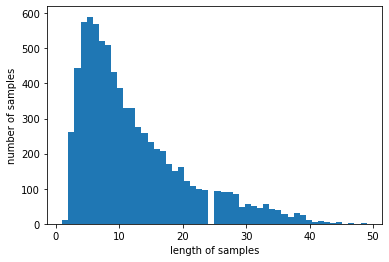

In [26]:
print('코멘트의 최대 길이 :',max(len(l) for l in x_train))
print('코멘트의 평균 길이 :',sum(map(len, x_train))/len(x_train))
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))
max_len = 30
below_threshold_len(max_len, x_train)


전체 샘플 중 길이가 30 이하인 샘플의 비율: 95.23809523809523


In [28]:
x_train = pad_sequences(x_train, maxlen = max_len)
x_val = pad_sequences(x_val, maxlen = max_len)
x_test = pad_sequences(x_test, maxlen = max_len)

In [29]:
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
bias_train = np.asarray(bias_train)
bias_val = np.asarray(bias_val)
hate_train = np.asarray(hate_train)
hate_val = np.asarray(hate_val)

In [30]:
import tensorflow as tf

print(type(x_train))
x_train = tf.convert_to_tensor(x_train)
x_val = tf.convert_to_tensor(x_val)
bias_train = tf.convert_to_tensor(bias_train)
bias_val = tf.convert_to_tensor(bias_val)
hate_train = tf.convert_to_tensor(hate_train)
hate_val = tf.convert_to_tensor(hate_val)

<class 'numpy.ndarray'>


# 모델

---



In [31]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [32]:
class Attention(tf.keras.Model):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    hidden_with_time_axis = tf.expand_dims(hidden,1)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [55]:
model_result = {}
test_pred = {}

In [60]:
def run(vocab_size, max_len, lstm_kind='LSTM', use_attention=False, cell_size=64, train_kind='bias') :
  embedding_dim = 100
  hidden_units = 128

  print('------------------------------------------------------------------------------------------')
  model_name = lstm_kind + " / " + str(use_attention) + " / " + str(cell_size) + " / " + train_kind
  print('model : '+ model_name)
  input = Input(shape=(max_len), dtype='int32')
  embedded = tf.keras.layers.Embedding(vocab_size, output_dim=embedding_dim, input_length=max_len)(input)

  if lstm_kind == 'LSTM' :
    lstm, forward_h, backward_h = LSTM(cell_size, activation = 'relu', return_state=True, return_sequences=True)(embedded)
  
  elif lstm_kind == 'BLSTM' :
    lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(cell_size, activation = 'relu',return_state=True, return_sequences=True))(embedded)
  
  else :
    print('lstm_kind 오류')

  state_h = Concatenate()([forward_h, backward_h])

  if use_attention :
    attention = Attention(128)
    context_vector, attention_weights = attention(lstm, state_h)
    hidden = tf.keras.layers.BatchNormalization()(context_vector)
  else :
    hidden = tf.keras.layers.BatchNormalization()(state_h)

  if train_kind == 'both' :
    bias_hidden = tf.keras.layers.Dense(32)(hidden)
    bias_output = tf.keras.layers.Dense(3, name='bias', activation='softmax')(bias_hidden)
    hate_hidden = tf.keras.layers.Dense(32)(hidden)
    hate_output = tf.keras.layers.Dense(3, name='hate', activation='softmax')(hate_hidden)
    model = tf.keras.Model(inputs=input, outputs=[bias_output, hate_output])
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(x_train, [bias_train, hate_train], epochs=25, batch_size=64, validation_data=(x_val, [bias_val, hate_val]))
    acc = model.evaluate(x_val, [bias_val, hate_val])[-2:]
    print(f'Validation accuracy : {acc[0]}(bias) {acc[1]}(hate)')
  
  elif train_kind == 'bias' :
    bias_hidden = tf.keras.layers.Dense(32)(hidden)
    bias_output = tf.keras.layers.Dense(3, name='bias', activation='softmax')(bias_hidden)
    model = tf.keras.Model(inputs=input, outputs=[bias_output])
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(x_train, bias_train, epochs=25, batch_size=64, validation_data=(x_val, bias_val))
    acc = model.evaluate(x_val, bias_val)[1]
    print(f'Validation accuracy : {acc}')
  
  elif train_kind == 'hate' :
    hate_hidden = tf.keras.layers.Dense(32)(hidden)
    hate_output = tf.keras.layers.Dense(3, name='hate', activation='softmax')(hate_hidden)
    model = tf.keras.Model(inputs=input, outputs=[hate_output])
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(x_train, hate_train, epochs=25, batch_size=64, validation_data=(x_val, hate_val))
    acc = model.evaluate(x_val, hate_val)[1]
    print(f'Validation accuracy : {acc}')

  else :
    print('train_kind 오류')

  model_result[model_name] = acc
  pred = []
  for t in x_test[:10] :
    t = t.reshape((-1, t.shape[0]))
    res = model.predict(t)
    if len(res)==2:
      pred.append([np.argmax(res[0]), np.argmax(res[1])])
    else :
      pred.append(np.argmax(res))
  test_pred[model_name] = pred
    

In [ ]:
for i in ['LSTM', 'BLSTM']:
  for j in [True, False]:
    for k in [64,128,256]:
      for l in ['both', 'bias', 'hate']:
        run(vocab_size, max_len, i, j, k, l)

------------------------------------------------------------------------------------------
model : LSTM / True / 64 / both
Epoch 1/25
124/124 [==============================] - 16s 106ms/step - loss: 1.0602 - bias_loss: 0.4830 - hate_loss: 0.5772 - bias_acc: 0.6764 - hate_acc: 0.5274 - val_loss: 1.0848 - val_bias_loss: 0.4489 - val_hate_loss: 0.6359 - val_bias_acc: 0.7261 - val_hate_acc: 0.3397
Epoch 2/25
124/124 [==============================] - 12s 97ms/step - loss: 0.7866 - bias_loss: 0.3372 - hate_loss: 0.4494 - bias_acc: 0.7841 - hate_acc: 0.6707 - val_loss: 1.0575 - val_bias_loss: 0.4303 - val_hate_loss: 0.6271 - val_bias_acc: 0.7261 - val_hate_acc: 0.3439
Epoch 3/25
124/124 [==============================] - 12s 94ms/step - loss: 0.6086 - bias_loss: 0.2551 - hate_loss: 0.3535 - bias_acc: 0.8487 - hate_acc: 0.7676 - val_loss: 0.9751 - val_bias_loss: 0.3837 - val_hate_loss: 0.5914 - val_bias_acc: 0.7389 - val_hate_acc: 0.5096
Epoch 4/25
124/124 [==============================] - 

# 정확도 및 예측

---



## 1. 정확도 순위

In [ ]:
bias_acc = {}
for key, value in model_result.items() :
  if 'both' in key :
    bias_acc[key] =  value[0]
  elif 'bias' in key :
    bias_acc[key] =  value

sorted_bias_acc = sorted(bias_acc.items(), key = lambda item : item[1], reverse=True)

print("====== 편견 표현 검증 정확도 순위 ====== ")
for key, value in sorted_bias_acc :
  print(f'{key} - acc : {value}')

In [ ]:
hate_acc = {}
for key, value in model_result.items() :
  if 'both' in key :
    hate_acc[key] =  value[0]
  elif 'hate' in key :
    hate_acc[key] =  value

sorted_hate_acc = sorted(hate_acc.items(), key = lambda item : item[1], reverse=True)

print("====== 혐오 표현 검증 정확도 순위 ====== ")
for key, value in sorted_hate_acc :
  print(f'{key} - acc : {value}')

## 2. 테스트 데이터 예측

In [ ]:
bias_name = ['gender', 'other', 'none']
hate_name = ['hate', 'offensive', 'none']

for key, value in model_result.items() :
  print('> model : ', key)
  if 'both' in key :
    for i in range(10) :
      print('>> comments :'+ x_test[i]['comments'])
      print('>> bias : '+ bias_name[test_pred[key][i][0]] + 'hate : '+ hate_name[test_pred[key][i][1]])
  elif 'bias' in key :
    for i in range(10) :
      print('>> comments :'+ x_test[i]['comments'])
      print('>> bias : '+ bias_name[test_pred[key][i])
  elif 'hate' in key :
    for i in range(10) :
      print('>> comments :'+ x_test[i]['comments'])
      print('>> hate : '+ bias_name[test_pred[key][i])
  print()

# 평가


---




36가지의 경우로 모델을 돌리고자 하였으나 시간 관계상 돌리지 못했습니다.

정확도 순위와 테스트 데이터 예측을 위한 코드를 챕터 - 정확도 및 예측으로 제시했습니다.